In [1]:
import os
from PIL import Image
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

print('Modules loaded successfully')

Modules loaded successfully


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_path='/content/drive/MyDrive/data/train'
valid_path='/content/drive/MyDrive/data/validation'
test_path='/content/drive/MyDrive/data/test'

In [4]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path,target_size=(224,224),classes=['cloudy','rain','shine','sunrise'],batch_size=50)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path,target_size=(224,224),classes=['cloudy','rain','shine','sunrise'],batch_size=50)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path,target_size=(224,224),classes=['cloudy','rain','shine','sunrise'],batch_size=50,shuffle=False)

Found 364 images belonging to 4 classes.
Found 313 images belonging to 4 classes.
Found 448 images belonging to 4 classes.


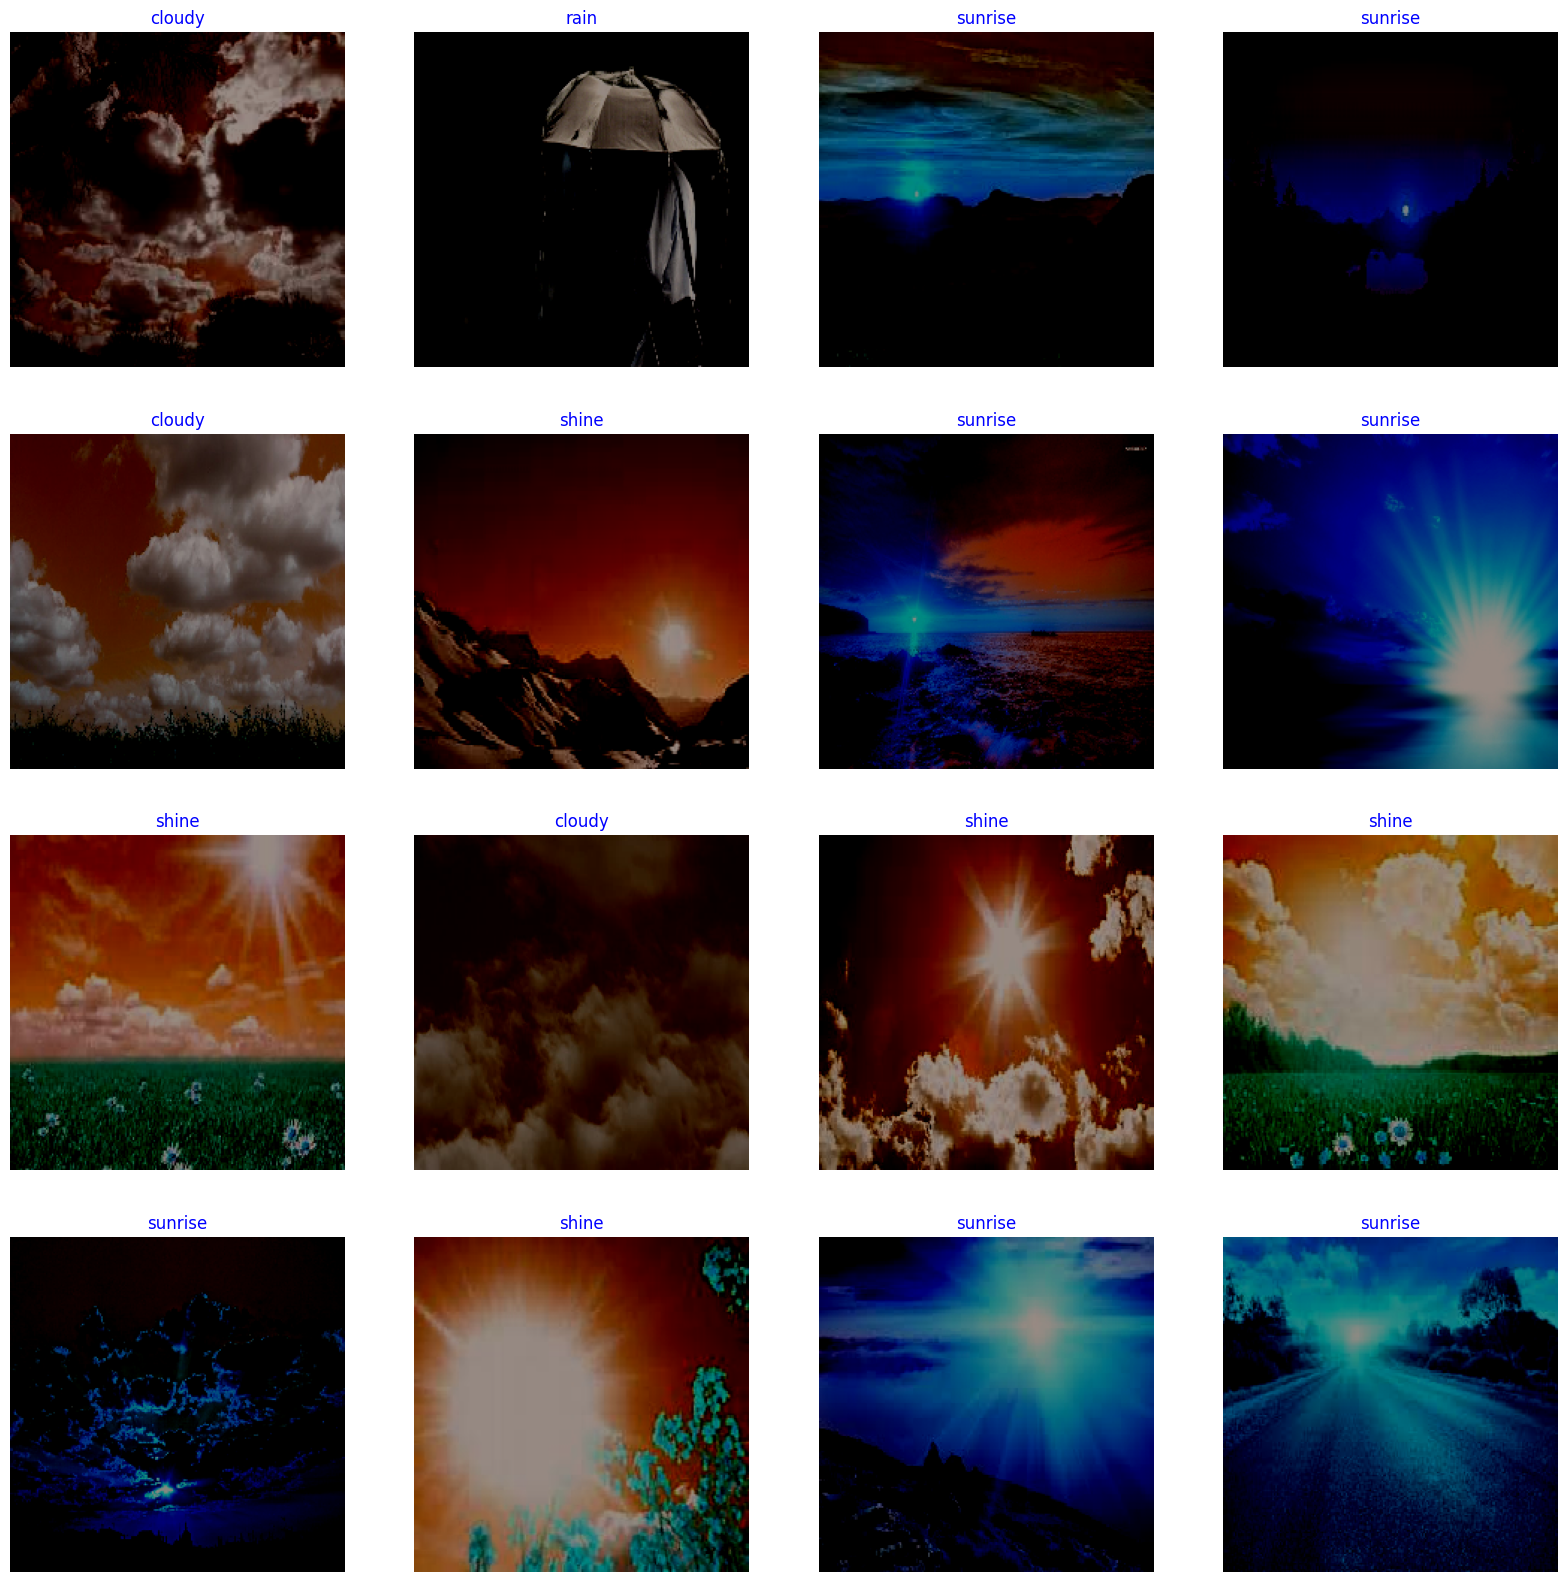

In [5]:
g_dict = train_batches.class_indices
classes = list(g_dict.keys())
images, labels = next(train_batches)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [6]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_batches.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                               input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy',
              metrics= ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

In [7]:
epochs = 15

hist = model.fit(train_batches, epochs = epochs, verbose = 1, validation_data = valid_batches, shuffle = False)

Epoch 1/15
8/8 [==============================] - 283s 31s/step - loss: 8.9983 - accuracy: 0.5495 - precision: 0.5920 - recall: 0.4863 - auc: 0.7922 - val_loss: 14.2911 - val_accuracy: 0.3131 - val_precision: 0.3141 - val_recall: 0.3131 - val_auc: 0.5779
Epoch 2/15
8/8 [==============================] - 9s 1s/step - loss: 7.8741 - accuracy: 0.8929 - precision: 0.9011 - recall: 0.8764 - auc: 0.9825 - val_loss: 13.0156 - val_accuracy: 0.3834 - val_precision: 0.3859 - val_recall: 0.3834 - val_auc: 0.6283
Epoch 3/15
8/8 [==============================] - 8s 1s/step - loss: 7.4639 - accuracy: 0.9588 - precision: 0.9665 - recall: 0.9505 - auc: 0.9983 - val_loss: 10.9249 - val_accuracy: 0.4665 - val_precision: 0.4721 - val_recall: 0.4601 - val_auc: 0.7152
Epoch 4/15
8/8 [==============================] - 8s 996ms/step - loss: 7.2282 - accuracy: 0.9753 - precision: 0.9751 - recall: 0.9698 - auc: 0.9984 - val_loss: 9.5117 - val_accuracy: 0.5751 - val_precision: 0.5784 - val_recall: 0.5655 - val

In [8]:
train_score = model.evaluate(train_batches)
valid_score = model.evaluate(valid_batches)
test_score = model.evaluate(test_batches)

9/9 [==============================] - 146s 18s/step - loss: 5.2480 - accuracy: 0.8795 - precision: 0.8963 - recall: 0.8683 - auc: 0.9812


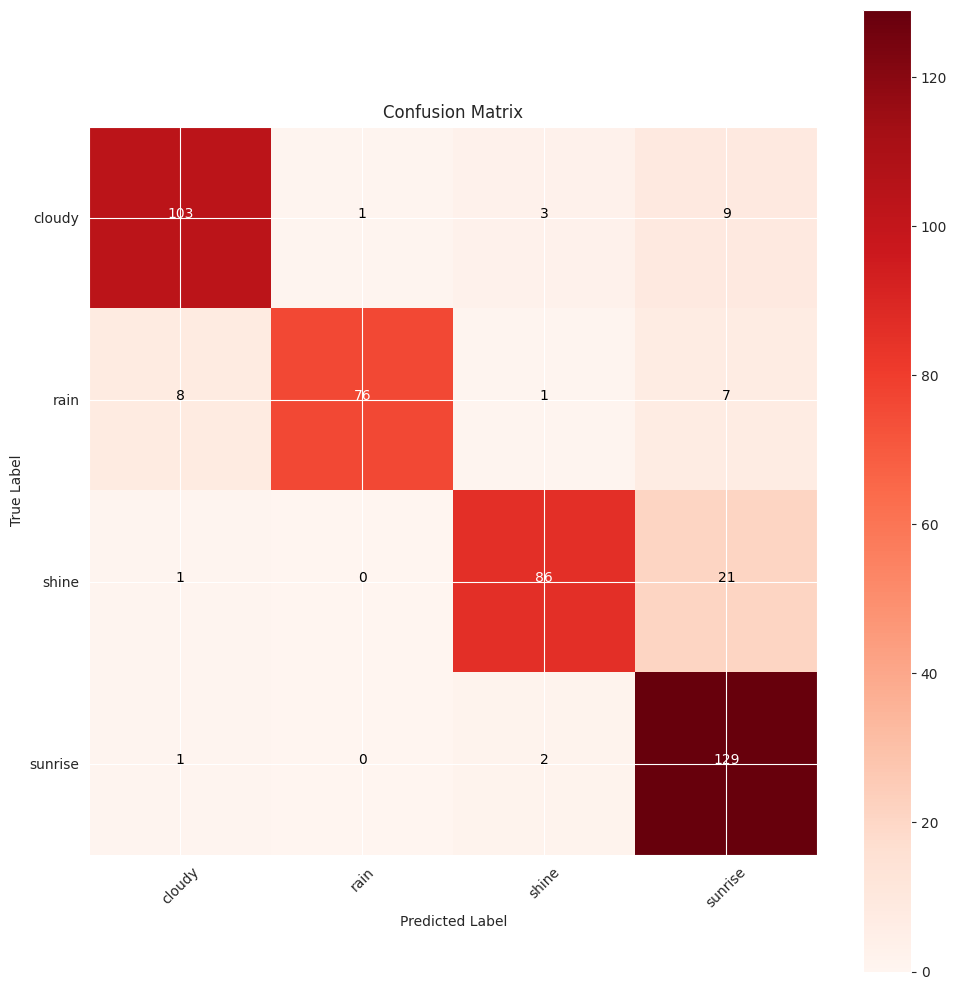

In [9]:
preds = model.predict_generator(test_batches)
y_pred= np.argmax(preds,axis=1)

g_dict = test_batches.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_batches.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): #(5,5)
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [10]:
model.save('/content/drive/MyDrive/my_model1.h5')

In [11]:
model.save('my_model1.keras')

"cloudy","rain","shine","sunrise"

In [14]:
from google.colab import files
from keras.preprocessing import image
import numpy as np
from keras.models import load_model

# Mount Google Drive if necessary
# from google.colab import drive
# drive.mount('/content/drive')

# Load the trained model
#model_path = '/content/drive/MyDrive/my_model.h5'  # Replace with the path to your trained model
#model = load_model(model_path)

# Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Assuming input shape is (224, 224)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Upload an image to Colab
uploaded = files.upload()

# Get the uploaded image path
img_path = list(uploaded.keys())[0]

# Preprocess the input image
input_img = preprocess_image(img_path)

# Perform inference to predict the class
predictions = model.predict(input_img)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Map the class index to the corresponding class label
class_labels = ["cloudy","rain","shine","sunrise"]  # Replace with your class labels
predicted_class_label = class_labels[predicted_class_index]

# Display the predicted class
print("Predicted class:", predicted_class_label)


Saving sunrise19.jpg to sunrise19.jpg
1/1 [==============================] - 0s 31ms/step
Predicted class: sunrise
